### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


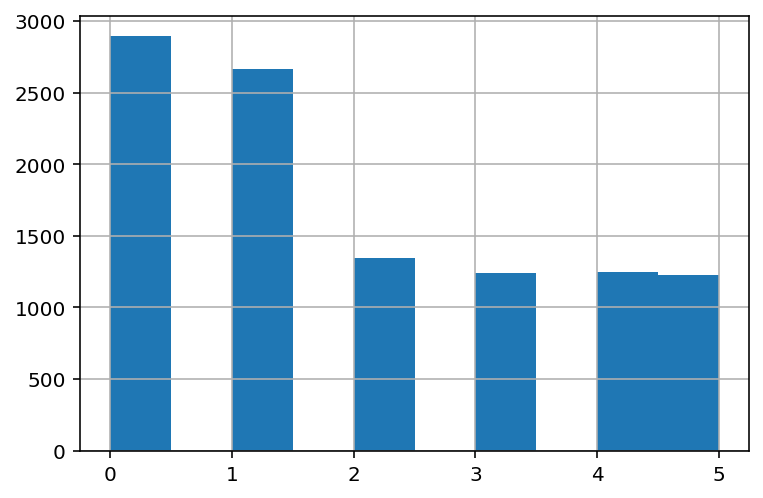

In [8]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [9]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
print(EXP_NAME)

14-05-2020-16-47


In [10]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

In [11]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

In [12]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
}

### Train Eval Loop

In [13]:
def train_eval_loop(train_dataloader, val_dataloader, model, optimizer, criterion, 
                    schedule_type=CFG.schedule_type, num_epochs=CFG.epoch, device=device, tb_tag="", model_name="debug"):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step)
    
    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0])
        writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=step, dataformats="HWC")
        del img
    
    def preds_to_tb(outputs, inputs, labels, step):
        figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu'))
        writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step)
        
    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(f"On best {mode} save at epoch:", 
                        f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}", 
                        global_step=step)
    
    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds),
                          global_step=step)
        
    # schedulers
    def get_scheduler(schedule_type=schedule_type):
        assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
        if schedule_type == "reduce_on_plateau":
            return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp, verbose=True), 
                    SCHEDULERS[schedule_type][1])
        if schedule_type == "one_cycle":
            return (SCHEDULERS[schedule_type][0](optimizer, max_lr=CFG.lr, steps_per_epoch=len(train_dataloader), epochs=num_epochs, pct_start=0.2),
                    SCHEDULERS[schedule_type][1])
        
        
    
    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()
    
    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp: # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    scheduler, sch_is_epoch_type = get_scheduler()
    # define epochs numbers to look into input images and predictions, no more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)

        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
            # Add Batch Type Scheduler step here:
            if not sch_is_epoch_type:
                scheduler.step()
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                preds_to_tb(outputs, inputs, labels, val_global_step)
        
        # Epoch type Schedulers
        if sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_loss.pth')
            # add losses as text to TB
            metrics_to_tb("loss", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_qwk.pth')
            # add losses and qwk as text to TB
            metrics_to_tb("qwk", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)  
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
    # End of loop
    writer.close()

### Prepare CV - strategy

In [14]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [15]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [16]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [18]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [19]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False use_amp: True img_height: 512 img_width: 512 lr: 0.0001 batch_size: 16 epoch: 50 seed: 1982 target_size: 6 img_id_col: image_id target_col: isup_grade n_fold: 4 tiff_layer: 1 loss: ls_soft_ce


In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [22]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug="heavy"), debug=False) # NOTE! it is predefined 36-tiles images
val_ds = LazyTilesDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=30)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/29


100%|██████████| 166/166 [00:15<00:00, 10.67it/s]


Training Loss: 1.4133	Validation Loss: 1.3378
Counter train preds: Counter({0: 3171, 1: 2178, 5: 974, 3: 583, 4: 559, 2: 497})	Counter val preds: Counter({1: 964, 0: 951, 2: 237, 4: 185, 3: 164, 5: 153})
Epoch train QWK: 0.590	val QWK: 0.636
  Epoch 0 - Save Best Loss: 1.3378 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
  Epoch 0 - Save Best QWK: 0.6357 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
Epoch 1/29


100%|██████████| 166/166 [00:14<00:00, 11.12it/s]


Training Loss: 1.3243	Validation Loss: 1.2604
Counter train preds: Counter({0: 3068, 1: 2105, 5: 931, 3: 659, 4: 614, 2: 585})	Counter val preds: Counter({0: 1165, 5: 408, 1: 357, 2: 345, 3: 195, 4: 184})
Epoch train QWK: 0.663	val QWK: 0.723
  Epoch 1 - Save Best Loss: 1.2604 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
  Epoch 1 - Save Best QWK: 0.7233 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
Epoch 2/29


100%|██████████| 166/166 [00:14<00:00, 11.36it/s]


Training Loss: 1.2768	Validation Loss: 1.2445
Counter train preds: Counter({0: 2990, 1: 2062, 5: 903, 4: 712, 2: 654, 3: 641})	Counter val preds: Counter({0: 988, 1: 664, 5: 486, 3: 310, 4: 129, 2: 77})
Epoch train QWK: 0.694	val QWK: 0.724
  Epoch 2 - Save Best Loss: 1.2445 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
  Epoch 2 - Save Best QWK: 0.7243 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
Epoch 3/29


100%|██████████| 166/166 [00:16<00:00, 10.25it/s]


Training Loss: 1.2524	Validation Loss: 1.2349
Counter train preds: Counter({0: 2952, 1: 2107, 5: 934, 3: 729, 4: 638, 2: 602})	Counter val preds: Counter({1: 836, 0: 797, 5: 349, 3: 253, 4: 229, 2: 190})
Epoch train QWK: 0.708	val QWK: 0.764
  Epoch 3 - Save Best Loss: 1.2349 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
  Epoch 3 - Save Best QWK: 0.7642 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
Epoch 4/29


100%|██████████| 166/166 [00:15<00:00, 10.78it/s]

Training Loss: 1.2235	Validation Loss: 1.2475
Counter train preds: Counter({0: 2866, 1: 2110, 5: 923, 4: 713, 3: 677, 2: 673})	Counter val preds: Counter({0: 1068, 1: 627, 4: 370, 3: 248, 5: 245, 2: 96})
Epoch train QWK: 0.727	val QWK: 0.739
Epoch 5/29



100%|██████████| 166/166 [00:14<00:00, 11.65it/s]


Training Loss: 1.2193	Validation Loss: 1.2217
Counter train preds: Counter({0: 2865, 1: 2125, 5: 921, 3: 716, 4: 712, 2: 623})	Counter val preds: Counter({1: 887, 0: 850, 3: 307, 4: 232, 2: 218, 5: 160})
Epoch train QWK: 0.735	val QWK: 0.727
  Epoch 5 - Save Best Loss: 1.2217 Model
Confusion matrix, without normalization
[[616  87   2   3   9   6]
 [134 488  24  17   3   0]
 [ 20 209  74  22   7   3]
 [ 28  46  73 130  19  15]
 [ 26  48  24  68 123  24]
 [ 26   9  21  67  71 112]]
Epoch 6/29


100%|██████████| 166/166 [00:15<00:00, 10.50it/s]

Training Loss: 1.1916	Validation Loss: 1.2237
Counter train preds: Counter({0: 2830, 1: 2097, 5: 913, 3: 743, 4: 722, 2: 657})	Counter val preds: Counter({1: 895, 0: 872, 3: 277, 5: 261, 2: 209, 4: 140})
Epoch train QWK: 0.751	val QWK: 0.734
Epoch 7/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]

Training Loss: 1.1780	Validation Loss: 1.2794
Counter train preds: Counter({0: 2802, 1: 2125, 5: 923, 4: 728, 3: 724, 2: 660})	Counter val preds: Counter({0: 1195, 1: 461, 5: 338, 4: 308, 2: 241, 3: 111})
Epoch train QWK: 0.760	val QWK: 0.724
Epoch 8/29



  6%|▋         | 32/498 [00:10<02:30,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.45it/s]

Training Loss: 1.1537	Validation Loss: 1.2326
Counter train preds: Counter({0: 2766, 1: 2073, 5: 922, 4: 753, 2: 727, 3: 721})	Counter val preds: Counter({0: 970, 1: 600, 4: 415, 5: 261, 2: 222, 3: 186})
Epoch train QWK: 0.775	val QWK: 0.742
Epoch 9/29



100%|██████████| 166/166 [00:17<00:00,  9.62it/s]

Epoch    10: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 1.1571	Validation Loss: 1.2449
Counter train preds: Counter({0: 2746, 1: 2079, 5: 912, 3: 791, 4: 745, 2: 689})	Counter val preds: Counter({1: 1001, 0: 814, 5: 246, 2: 221, 3: 219, 4: 153})
Epoch train QWK: 0.767	val QWK: 0.717
Epoch 10/29



100%|██████████| 166/166 [00:14<00:00, 11.80it/s]


Training Loss: 1.0783	Validation Loss: 1.1852
Counter train preds: Counter({0: 2674, 1: 2077, 5: 928, 4: 786, 3: 769, 2: 728})	Counter val preds: Counter({0: 872, 1: 686, 5: 383, 4: 269, 3: 233, 2: 211})
Epoch train QWK: 0.814	val QWK: 0.762
  Epoch 10 - Save Best Loss: 1.1852 Model
Confusion matrix, without normalization
[[633  62   2   5  11  10]
 [139 424  55  26  22   0]
 [ 22 136  95  43  22  17]
 [ 27  31  33 110  43  67]
 [ 27  27  19  35 128  77]
 [ 24   6   7  14  43 212]]
Epoch 11/29


100%|██████████| 166/166 [00:14<00:00, 11.79it/s]


Training Loss: 1.0550	Validation Loss: 1.2170
Counter train preds: Counter({0: 2645, 1: 2025, 5: 936, 4: 803, 2: 797, 3: 756})	Counter val preds: Counter({0: 968, 1: 566, 5: 453, 2: 265, 3: 220, 4: 182})
Epoch train QWK: 0.819	val QWK: 0.766
  Epoch 11 - Save Best QWK: 0.7663 Model
Confusion matrix, without normalization
[[662  45   2   4   3   7]
 [181 366  84  13  15   7]
 [ 35  99 121  45  16  19]
 [ 32  23  34 109  27  86]
 [ 31  29  15  38  97 103]
 [ 27   4   9  11  24 231]]
Epoch 12/29


  8%|▊         | 42/498 [00:13<02:11,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:16<00:00, 10.31it/s]

Training Loss: 1.0295	Validation Loss: 1.2241
Counter train preds: Counter({0: 2631, 1: 2021, 5: 895, 2: 815, 4: 801, 3: 799})	Counter val preds: Counter({0: 921, 1: 797, 5: 258, 3: 255, 4: 222, 2: 201})
Epoch train QWK: 0.821	val QWK: 0.754
Epoch 13/29



100%|██████████| 166/166 [00:14<00:00, 11.82it/s]

Training Loss: 1.0086	Validation Loss: 1.2355
Counter train preds: Counter({0: 2553, 1: 2047, 5: 940, 2: 815, 4: 813, 3: 794})	Counter val preds: Counter({0: 995, 1: 581, 2: 387, 5: 293, 3: 214, 4: 184})
Epoch train QWK: 0.843	val QWK: 0.752
Epoch 14/29



100%|██████████| 166/166 [00:14<00:00, 11.78it/s]

Epoch    15: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 0.9891	Validation Loss: 1.2672
Counter train preds: Counter({0: 2550, 1: 2031, 5: 919, 3: 833, 2: 832, 4: 797})	Counter val preds: Counter({0: 854, 1: 731, 4: 385, 5: 364, 2: 190, 3: 130})
Epoch train QWK: 0.844	val QWK: 0.763
Epoch 15/29



100%|██████████| 166/166 [00:15<00:00, 10.71it/s]


Training Loss: 0.9256	Validation Loss: 1.2372
Counter train preds: Counter({0: 2517, 1: 2001, 5: 894, 2: 886, 4: 846, 3: 818})	Counter val preds: Counter({0: 888, 1: 612, 3: 362, 2: 285, 5: 260, 4: 247})
Epoch train QWK: 0.868	val QWK: 0.767
  Epoch 15 - Save Best QWK: 0.7666 Model
Confusion matrix, without normalization
[[631  70   3  13   2   4]
 [146 389  85  35   9   2]
 [ 27  98 137  56  13   4]
 [ 30  21  39 151  38  32]
 [ 30  21  15  67 135  45]
 [ 24  13   6  40  50 173]]
Epoch 16/29


 13%|█▎        | 67/498 [00:20<02:05,  3.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.9068	Validation Loss: 1.2451
Counter train preds: Counter({0: 2501, 1: 1981, 5: 924, 2: 901, 3: 831, 4: 824})	Counter val preds: Counter({0: 868, 1: 740, 2: 287, 3: 280, 5: 247, 4: 232})
Epoch train QWK: 0.876	val QWK: 0.754
Epoch 17/29



100%|██████████| 166/166 [00:15<00:00, 10.44it/s]

Training Loss: 0.8845	Validation Loss: 1.2586
Counter train preds: Counter({0: 2483, 1: 1987, 5: 913, 2: 888, 4: 866, 3: 825})	Counter val preds: Counter({0: 844, 1: 579, 5: 348, 3: 298, 2: 296, 4: 289})
Epoch train QWK: 0.881	val QWK: 0.764
Epoch 18/29



100%|██████████| 166/166 [00:15<00:00, 10.56it/s]

Epoch    19: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.8628	Validation Loss: 1.2978
Counter train preds: Counter({0: 2465, 1: 1989, 5: 915, 2: 894, 4: 864, 3: 835})	Counter val preds: Counter({0: 817, 1: 634, 2: 407, 5: 305, 3: 289, 4: 202})
Epoch train QWK: 0.893	val QWK: 0.763
Epoch 19/29



100%|██████████| 166/166 [00:14<00:00, 11.44it/s]


Training Loss: 0.8329	Validation Loss: 1.2674
Counter train preds: Counter({0: 2413, 1: 2033, 2: 935, 5: 906, 4: 867, 3: 808})	Counter val preds: Counter({0: 843, 1: 638, 2: 380, 5: 292, 4: 253, 3: 248})
Epoch train QWK: 0.897	val QWK: 0.771
  Epoch 19 - Save Best QWK: 0.7708 Model
Confusion matrix, without normalization
[[617  87   7   4   3   5]
 [127 398 113  17   7   4]
 [ 23  95 157  44  13   3]
 [ 25  24  64 112  44  42]
 [ 24  25  26  42 135  61]
 [ 27   9  13  29  51 177]]
Epoch 20/29


 18%|█▊        | 90/498 [00:28<02:00,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.74it/s]


Training Loss: 0.8309	Validation Loss: 1.2587
Counter train preds: Counter({0: 2444, 1: 1971, 2: 946, 5: 906, 4: 855, 3: 840})	Counter val preds: Counter({0: 905, 1: 645, 5: 348, 2: 288, 4: 254, 3: 214})
Epoch train QWK: 0.895	val QWK: 0.772
  Epoch 20 - Save Best QWK: 0.7721 Model
Confusion matrix, without normalization
[[638  67   7   5   2   4]
 [156 399  82  11  13   5]
 [ 27 112 129  38  19  10]
 [ 30  31  46 104  49  51]
 [ 29  25  16  32 137  74]
 [ 25  11   8  24  34 204]]
Epoch 21/29


100%|██████████| 166/166 [00:16<00:00, 10.07it/s]

Training Loss: 0.8118	Validation Loss: 1.2990
Counter train preds: Counter({0: 2425, 1: 1992, 2: 920, 5: 913, 4: 863, 3: 849})	Counter val preds: Counter({0: 863, 1: 560, 2: 397, 4: 287, 3: 274, 5: 273})
Epoch train QWK: 0.904	val QWK: 0.766
Epoch 22/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]


Epoch    23: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.8106	Validation Loss: 1.2867
Counter train preds: Counter({0: 2392, 1: 2022, 2: 934, 5: 910, 4: 880, 3: 824})	Counter val preds: Counter({0: 844, 1: 588, 2: 388, 5: 310, 4: 274, 3: 250})
Epoch train QWK: 0.898	val QWK: 0.773
  Epoch 22 - Save Best QWK: 0.7731 Model
Confusion matrix, without normalization
[[610  87  10   6   5   5]
 [139 365 121  26  10   5]
 [ 24  80 164  46  17   4]
 [ 21  24  62 114  45  45]
 [ 25  24  18  39 147  60]
 [ 25   8  13  19  50 191]]
Epoch 23/29


100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Training Loss: 0.7927	Validation Loss: 1.2908
Counter train preds: Counter({0: 2397, 1: 1984, 5: 944, 2: 931, 3: 874, 4: 832})	Counter val preds: Counter({0: 840, 1: 644, 2: 377, 5: 274, 3: 270, 4: 249})
Epoch train QWK: 0.906	val QWK: 0.766
Epoch 24/29



 41%|████      | 204/498 [01:01<01:24,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:15<00:00, 10.47it/s]

Training Loss: 0.7887	Validation Loss: 1.2833
Counter train preds: Counter({0: 2403, 1: 1975, 2: 947, 5: 891, 4: 890, 3: 856})	Counter val preds: Counter({0: 863, 1: 672, 2: 376, 4: 297, 5: 265, 3: 181})
Epoch train QWK: 0.906	val QWK: 0.760
Epoch 25/29



100%|██████████| 166/166 [00:14<00:00, 11.74it/s]

Training Loss: 0.7820	Validation Loss: 1.2766
Counter train preds: Counter({0: 2399, 1: 1977, 2: 951, 5: 904, 4: 874, 3: 857})	Counter val preds: Counter({0: 859, 1: 629, 2: 323, 3: 313, 5: 275, 4: 255})
Epoch train QWK: 0.907	val QWK: 0.765
Epoch 26/29



100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.7875	Validation Loss: 1.2824
Counter train preds: Counter({0: 2443, 1: 1964, 2: 935, 5: 905, 3: 877, 4: 838})	Counter val preds: Counter({0: 838, 1: 655, 2: 371, 5: 292, 3: 290, 4: 208})
Epoch train QWK: 0.906	val QWK: 0.759
Epoch 27/29



100%|██████████| 166/166 [00:15<00:00, 10.60it/s]

Training Loss: 0.7610	Validation Loss: 1.3068
Counter train preds: Counter({0: 2411, 1: 1954, 2: 952, 5: 937, 4: 861, 3: 847})	Counter val preds: Counter({0: 886, 1: 561, 2: 348, 3: 338, 5: 284, 4: 237})
Epoch train QWK: 0.917	val QWK: 0.759
Epoch 28/29



 51%|█████▏    | 256/498 [01:17<01:09,  3.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.7612	Validation Loss: 1.2853
Counter train preds: Counter({0: 2396, 1: 1962, 2: 947, 5: 916, 4: 880, 3: 861})	Counter val preds: Counter({0: 855, 1: 665, 2: 342, 5: 313, 3: 248, 4: 231})
Epoch train QWK: 0.917	val QWK: 0.764
Epoch 29/29



100%|██████████| 166/166 [00:14<00:00, 11.73it/s]

Training Loss: 0.7683	Validation Loss: 1.2812
Counter train preds: Counter({0: 2405, 1: 1990, 2: 934, 5: 886, 4: 880, 3: 867})	Counter val preds: Counter({0: 888, 1: 609, 2: 364, 5: 295, 3: 262, 4: 236})
Epoch train QWK: 0.914	val QWK: 0.762


### Experiment Run

In [17]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 use_amp: True
 img_height: 768
 img_width: 768
 lr: 0.0005
 rlopp: 3
 batch_size: 8
 epoch: 100
 seed: 1982
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 n_fold: 4
 tiff_layer: 1
 loss: ls_soft_ce
 stoch_sample: True
 num_tiles: 36
 tile_sz: 128
 schedule_type: one_cycle



In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [20]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug="light"), debug=False)
val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=4)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/99


100%|██████████| 332/332 [02:09<00:00,  2.57it/s]


Training Loss: 1.3795	Validation Loss: 1.2491
Counter train preds: Counter({0: 3211, 1: 2274, 5: 968, 4: 569, 3: 508, 2: 432})	Counter val preds: Counter({1: 902, 0: 886, 3: 263, 5: 239, 2: 221, 4: 143})
Epoch train QWK: 0.580	val QWK: 0.706
  Epoch 0 - Save Best Loss: 1.2491 Model
Confusion matrix, without normalization
[[622  90   1   1   4   5]
 [126 486  42   6   3   3]
 [ 28 196  86  19   3   3]
 [ 37  72  57 105  13  27]
 [ 36  47  22  74  85  49]
 [ 37  11  13  58  35 152]]
  Epoch 0 - Save Best QWK: 0.7061 Model
Confusion matrix, without normalization
[[622  90   1   1   4   5]
 [126 486  42   6   3   3]
 [ 28 196  86  19   3   3]
 [ 37  72  57 105  13  27]
 [ 36  47  22  74  85  49]
 [ 37  11  13  58  35 152]]
Epoch 1/99


100%|██████████| 332/332 [02:07<00:00,  2.61it/s]


Training Loss: 1.2702	Validation Loss: 1.2184
Counter train preds: Counter({0: 2891, 1: 2223, 5: 923, 4: 715, 3: 606, 2: 604})	Counter val preds: Counter({0: 876, 1: 687, 5: 453, 2: 230, 4: 224, 3: 184})
Epoch train QWK: 0.685	val QWK: 0.757
  Epoch 1 - Save Best Loss: 1.2184 Model
Confusion matrix, without normalization
[[628  69   1   1   9  15]
 [133 427  75  17   6   8]
 [ 33 120 105  40  19  18]
 [ 38  32  26  88  37  90]
 [ 19  31  16  23 118 106]
 [ 25   8   7  15  35 216]]
  Epoch 1 - Save Best QWK: 0.7567 Model
Confusion matrix, without normalization
[[628  69   1   1   9  15]
 [133 427  75  17   6   8]
 [ 33 120 105  40  19  18]
 [ 38  32  26  88  37  90]
 [ 19  31  16  23 118 106]
 [ 25   8   7  15  35 216]]
Epoch 2/99


  4%|▎         | 36/996 [00:20<06:55,  2.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:02<00:00,  2.71it/s]


Training Loss: 1.2492	Validation Loss: 1.1923
Counter train preds: Counter({0: 2826, 1: 2187, 5: 893, 4: 747, 2: 657, 3: 652})	Counter val preds: Counter({0: 823, 1: 806, 5: 494, 3: 250, 2: 149, 4: 132})
Epoch train QWK: 0.700	val QWK: 0.774
  Epoch 2 - Save Best Loss: 1.1923 Model
Confusion matrix, without normalization
[[621  91   3   0   4   4]
 [103 485  51  14   4   9]
 [ 18 152  70  55  15  25]
 [ 32  40  14 105  22  98]
 [ 23  29   9  52  70 130]
 [ 26   9   2  24  17 228]]
  Epoch 2 - Save Best QWK: 0.7739 Model
Confusion matrix, without normalization
[[621  91   3   0   4   4]
 [103 485  51  14   4   9]
 [ 18 152  70  55  15  25]
 [ 32  40  14 105  22  98]
 [ 23  29   9  52  70 130]
 [ 26   9   2  24  17 228]]
Epoch 3/99


100%|██████████| 332/332 [02:04<00:00,  2.67it/s]

Training Loss: 1.2372	Validation Loss: 1.3405
Counter train preds: Counter({0: 2831, 1: 2190, 5: 938, 4: 680, 3: 678, 2: 645})	Counter val preds: Counter({0: 742, 1: 646, 5: 467, 3: 304, 4: 290, 2: 205})
Epoch train QWK: 0.702	val QWK: 0.757
Epoch 4/99



  9%|▊         | 85/996 [00:34<05:23,  2.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:02<00:00,  2.71it/s]

Training Loss: 1.2354	Validation Loss: 1.2378
Counter train preds: Counter({0: 2847, 1: 2201, 5: 907, 4: 722, 3: 648, 2: 637})	Counter val preds: Counter({0: 947, 1: 770, 3: 354, 5: 253, 2: 187, 4: 143})
Epoch train QWK: 0.713	val QWK: 0.742
Epoch 5/99



100%|██████████| 332/332 [02:06<00:00,  2.63it/s]


Training Loss: 1.2391	Validation Loss: 1.2145
Counter train preds: Counter({0: 2840, 1: 2199, 5: 890, 4: 760, 3: 680, 2: 593})	Counter val preds: Counter({0: 910, 1: 648, 3: 449, 4: 400, 5: 170, 2: 77})
Epoch train QWK: 0.712	val QWK: 0.784
  Epoch 5 - Save Best QWK: 0.7843 Model
Confusion matrix, without normalization
[[655  58   1   3   2   4]
 [154 422  24  51  10   5]
 [ 26 118  38 137  13   3]
 [ 31  22   9 157  66  26]
 [ 18  22   3  70 178  22]
 [ 26   6   2  31 131 110]]
Epoch 6/99


 20%|██        | 200/996 [01:20<05:02,  2.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:14<00:00,  2.47it/s]

Training Loss: 1.2347	Validation Loss: 1.2485
Counter train preds: Counter({0: 2873, 1: 2144, 5: 927, 4: 692, 2: 686, 3: 640})	Counter val preds: Counter({1: 1135, 0: 673, 5: 278, 3: 273, 4: 182, 2: 113})
Epoch train QWK: 0.723	val QWK: 0.744
Epoch 7/99



100%|██████████| 332/332 [02:12<00:00,  2.50it/s]

Training Loss: 1.2466	Validation Loss: 1.4599
Counter train preds: Counter({0: 2873, 1: 2183, 5: 908, 4: 750, 3: 639, 2: 609})	Counter val preds: Counter({0: 878, 5: 789, 1: 292, 4: 288, 2: 253, 3: 154})
Epoch train QWK: 0.707	val QWK: 0.661
Epoch 8/99



100%|██████████| 996/996 [06:07<00:00,  2.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 1.2436	Validation Loss: 1.3141
Counter train preds: Counter({0: 2837, 1: 2204, 5: 921, 4: 736, 2: 666, 3: 598})	Counter val preds: Counter({0: 948, 1: 825, 2: 367, 5: 269, 4: 189, 3: 56})
Epoch train QWK: 0.715	val QWK: 0.708
Epoch 9/99



100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.2501	Validation Loss: 1.5761
Counter train preds: Counter({0: 2925, 1: 2149, 5: 925, 4: 744, 3: 637, 2: 582})	Counter val preds: Counter({1: 1513, 0: 511, 2: 351, 5: 132, 4: 86, 3: 61})
Epoch train QWK: 0.706	val QWK: 0.549
Epoch 10/99



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 1.2513	Validation Loss: 1.3329
Counter train preds: Counter({0: 2884, 1: 2206, 5: 946, 4: 707, 3: 615, 2: 604})	Counter val preds: Counter({0: 737, 1: 654, 5: 551, 4: 369, 3: 207, 2: 136})
Epoch train QWK: 0.707	val QWK: 0.674
Epoch 11/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 1.2525	Validation Loss: 2.4569
Counter train preds: Counter({0: 2828, 1: 2243, 5: 933, 4: 726, 3: 642, 2: 590})	Counter val preds: Counter({1: 1485, 0: 767, 2: 207, 5: 127, 4: 35, 3: 33})
Epoch train QWK: 0.709	val QWK: 0.492
Epoch 12/99



 52%|█████▏    | 519/996 [03:03<02:47,  2.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.2496	Validation Loss: 1.3106
Counter train preds: Counter({0: 2884, 1: 2192, 5: 900, 4: 715, 3: 660, 2: 611})	Counter val preds: Counter({0: 910, 1: 642, 5: 365, 2: 335, 3: 330, 4: 72})
Epoch train QWK: 0.701	val QWK: 0.716
Epoch 13/99



100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.2421	Validation Loss: 1.2464
Counter train preds: Counter({0: 2902, 1: 2163, 5: 920, 4: 719, 3: 653, 2: 605})	Counter val preds: Counter({0: 1132, 1: 643, 5: 334, 4: 260, 2: 166, 3: 119})
Epoch train QWK: 0.697	val QWK: 0.711
Epoch 14/99



 82%|████████▏ | 816/996 [04:47<00:59,  3.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:02<00:00,  2.72it/s]

Training Loss: 1.2324	Validation Loss: 1.2642
Counter train preds: Counter({0: 2873, 1: 2175, 5: 956, 4: 705, 2: 629, 3: 624})	Counter val preds: Counter({1: 1086, 0: 808, 2: 215, 3: 201, 5: 178, 4: 166})
Epoch train QWK: 0.722	val QWK: 0.691
Epoch 15/99



100%|██████████| 332/332 [02:02<00:00,  2.72it/s]


Training Loss: 1.2256	Validation Loss: 1.1724
Counter train preds: Counter({0: 2836, 1: 2226, 5: 921, 4: 750, 3: 640, 2: 589})	Counter val preds: Counter({0: 850, 1: 804, 5: 371, 4: 215, 2: 208, 3: 206})
Epoch train QWK: 0.724	val QWK: 0.782
  Epoch 15 - Save Best Loss: 1.1724 Model
Confusion matrix, without normalization
[[649  60   1   8   2   3]
 [105 499  40  15   3   4]
 [ 23 155 102  35   8  12]
 [ 26  41  41  90  54  59]
 [ 23  34  18  37 116  85]
 [ 24  15   6  21  32 208]]
Epoch 16/99


 89%|████████▉ | 889/996 [05:13<00:37,  2.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:02<00:00,  2.72it/s]

Training Loss: 1.2301	Validation Loss: 1.2414
Counter train preds: Counter({0: 2864, 1: 2175, 5: 938, 4: 697, 3: 662, 2: 626})	Counter val preds: Counter({0: 863, 1: 655, 4: 345, 3: 313, 5: 313, 2: 165})
Epoch train QWK: 0.718	val QWK: 0.762
Epoch 17/99



100%|██████████| 332/332 [02:03<00:00,  2.69it/s]

Training Loss: 1.2118	Validation Loss: 1.3460
Counter train preds: Counter({0: 2823, 1: 2188, 5: 921, 4: 735, 3: 677, 2: 618})	Counter val preds: Counter({1: 1213, 0: 475, 5: 353, 2: 266, 3: 233, 4: 114})
Epoch train QWK: 0.725	val QWK: 0.759
Epoch 18/99



100%|██████████| 332/332 [02:02<00:00,  2.71it/s]


Training Loss: 1.2083	Validation Loss: 1.1859
Counter train preds: Counter({0: 2818, 1: 2199, 5: 923, 4: 723, 3: 715, 2: 584})	Counter val preds: Counter({0: 825, 1: 757, 4: 398, 2: 283, 5: 255, 3: 136})
Epoch train QWK: 0.739	val QWK: 0.785
  Epoch 18 - Save Best QWK: 0.7854 Model
Confusion matrix, without normalization
[[626  86   1   3   5   2]
 [106 476  62  14   6   2]
 [ 22 122 139  24  19   9]
 [ 27  31  48  56 112  37]
 [ 21  31  22  24 168  47]
 [ 23  11  11  15  88 158]]
Epoch 19/99


100%|██████████| 996/996 [06:08<00:00,  2.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 332/332 [02:06<00:00,  2.62it/s]

Training Loss: 1.1946	Validation Loss: 1.3916
Counter train preds: Counter({0: 2796, 1: 2183, 5: 949, 4: 696, 2: 671, 3: 667})	Counter val preds: Counter({0: 1118, 1: 797, 2: 345, 3: 213, 4: 147, 5: 34})
Epoch train QWK: 0.737	val QWK: 0.529
Epoch 20/99



100%|██████████| 332/332 [02:10<00:00,  2.54it/s]

Training Loss: 1.1905	Validation Loss: 1.2486
Counter train preds: Counter({0: 2814, 1: 2168, 5: 904, 4: 748, 3: 692, 2: 636})	Counter val preds: Counter({0: 909, 4: 536, 1: 506, 2: 295, 5: 293, 3: 115})
Epoch train QWK: 0.742	val QWK: 0.770
Epoch 21/99



100%|██████████| 332/332 [02:01<00:00,  2.72it/s]

Training Loss: 1.1742	Validation Loss: 1.1863
Counter train preds: Counter({0: 2789, 1: 2175, 5: 905, 4: 734, 3: 706, 2: 653})	Counter val preds: Counter({0: 899, 1: 570, 5: 401, 3: 362, 2: 224, 4: 198})
Epoch train QWK: 0.748	val QWK: 0.772
Epoch 22/99



  2%|▏         | 23/996 [00:12<05:41,  2.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 1.1696	Validation Loss: 1.2511
Counter train preds: Counter({0: 2757, 1: 2173, 5: 919, 4: 741, 3: 717, 2: 655})	Counter val preds: Counter({0: 994, 5: 577, 1: 434, 2: 323, 4: 169, 3: 157})
Epoch train QWK: 0.758	val QWK: 0.757
Epoch 23/99



100%|██████████| 332/332 [02:02<00:00,  2.71it/s]

Training Loss: 1.1589	Validation Loss: 1.1947
Counter train preds: Counter({0: 2724, 1: 2186, 5: 901, 4: 738, 2: 718, 3: 695})	Counter val preds: Counter({0: 868, 1: 808, 5: 442, 4: 340, 3: 100, 2: 96})
Epoch train QWK: 0.761	val QWK: 0.785
Epoch 24/99



 48%|████▊     | 482/996 [02:51<02:54,  2.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.1599	Validation Loss: 1.1961
Counter train preds: Counter({0: 2756, 1: 2158, 5: 921, 4: 752, 2: 699, 3: 676})	Counter val preds: Counter({0: 947, 1: 728, 5: 438, 3: 294, 4: 142, 2: 105})
Epoch train QWK: 0.762	val QWK: 0.766
Epoch 25/99



100%|██████████| 332/332 [02:01<00:00,  2.72it/s]


Training Loss: 1.1539	Validation Loss: 1.2303
Counter train preds: Counter({0: 2742, 1: 2164, 5: 879, 4: 787, 2: 699, 3: 691})	Counter val preds: Counter({0: 816, 1: 688, 3: 456, 5: 373, 2: 185, 4: 136})
Epoch train QWK: 0.764	val QWK: 0.789
  Epoch 25 - Save Best QWK: 0.7888 Model
Confusion matrix, without normalization
[[631  48   2  28   7   7]
 [114 461  40  45   2   4]
 [ 18 130  89  87   2   9]
 [ 24  19  38 156  19  55]
 [ 15  19  11  84  92  92]
 [ 14  11   5  56  14 206]]
Epoch 26/99


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 1.1445	Validation Loss: 1.1829
Counter train preds: Counter({0: 2769, 1: 2136, 5: 901, 4: 752, 3: 719, 2: 685})	Counter val preds: Counter({1: 940, 0: 764, 3: 282, 2: 246, 5: 225, 4: 197})
Epoch train QWK: 0.767	val QWK: 0.774
Epoch 27/99



 55%|█████▍    | 545/996 [03:12<02:55,  2.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.72it/s]


Training Loss: 1.1428	Validation Loss: 1.1604
Counter train preds: Counter({0: 2722, 1: 2169, 5: 916, 4: 765, 3: 730, 2: 660})	Counter val preds: Counter({0: 860, 1: 747, 4: 391, 2: 262, 5: 199, 3: 195})
Epoch train QWK: 0.764	val QWK: 0.798
  Epoch 27 - Save Best Loss: 1.1604 Model
Confusion matrix, without normalization
[[661  58   1   2   1   0]
 [ 96 498  51  14   6   1]
 [ 19 137 131  32  14   2]
 [ 34  21  46  98  96  16]
 [ 22  24  23  25 189  30]
 [ 28   9  10  24  85 150]]
  Epoch 27 - Save Best QWK: 0.7983 Model
Confusion matrix, without normalization
[[661  58   1   2   1   0]
 [ 96 498  51  14   6   1]
 [ 19 137 131  32  14   2]
 [ 34  21  46  98  96  16]
 [ 22  24  23  25 189  30]
 [ 28   9  10  24  85 150]]
Epoch 28/99


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.1308	Validation Loss: 1.2325
Counter train preds: Counter({0: 2699, 1: 2183, 5: 905, 4: 755, 3: 712, 2: 708})	Counter val preds: Counter({0: 945, 1: 617, 5: 495, 3: 229, 4: 212, 2: 156})
Epoch train QWK: 0.773	val QWK: 0.766
Epoch 29/99



100%|██████████| 332/332 [02:01<00:00,  2.73it/s]


Training Loss: 1.1240	Validation Loss: 1.1472
Counter train preds: Counter({0: 2725, 1: 2151, 5: 884, 4: 783, 3: 718, 2: 701})	Counter val preds: Counter({0: 916, 1: 672, 5: 379, 3: 322, 2: 189, 4: 176})
Epoch train QWK: 0.785	val QWK: 0.801
  Epoch 29 - Save Best Loss: 1.1472 Model
Confusion matrix, without normalization
[[676  36   4   3   2   2]
 [139 448  51  21   5   2]
 [ 23 139  94  59  10  10]
 [ 30  20  28 139  29  65]
 [ 23  21   9  65 104  91]
 [ 25   8   3  35  26 209]]
  Epoch 29 - Save Best QWK: 0.8005 Model
Confusion matrix, without normalization
[[676  36   4   3   2   2]
 [139 448  51  21   5   2]
 [ 23 139  94  59  10  10]
 [ 30  20  28 139  29  65]
 [ 23  21   9  65 104  91]
 [ 25   8   3  35  26 209]]
Epoch 30/99


 85%|████████▌ | 848/996 [05:14<00:54,  2.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.74it/s]


Training Loss: 1.1186	Validation Loss: 1.1396
Counter train preds: Counter({0: 2694, 1: 2174, 5: 887, 4: 769, 3: 725, 2: 713})	Counter val preds: Counter({0: 789, 1: 767, 2: 307, 4: 284, 5: 258, 3: 249})
Epoch train QWK: 0.787	val QWK: 0.797
  Epoch 30 - Save Best Loss: 1.1396 Model
Confusion matrix, without normalization
[[625  79   1   4  10   4]
 [ 93 497  52  13   9   2]
 [ 15 130 150  29   9   2]
 [ 24  27  61 119  55  25]
 [ 13  21  28  48 151  52]
 [ 19  13  15  36  50 173]]
Epoch 31/99


100%|██████████| 332/332 [02:04<00:00,  2.67it/s]

Training Loss: 1.1183	Validation Loss: 1.2216
Counter train preds: Counter({0: 2713, 1: 2165, 5: 875, 4: 764, 2: 726, 3: 719})	Counter val preds: Counter({0: 865, 1: 765, 4: 387, 3: 382, 5: 146, 2: 109})
Epoch train QWK: 0.786	val QWK: 0.782
Epoch 32/99



100%|██████████| 332/332 [02:07<00:00,  2.60it/s]

Training Loss: 1.1178	Validation Loss: 1.1489
Counter train preds: Counter({0: 2668, 1: 2160, 5: 874, 4: 788, 2: 754, 3: 718})	Counter val preds: Counter({0: 932, 1: 644, 3: 360, 2: 282, 5: 255, 4: 181})
Epoch train QWK: 0.783	val QWK: 0.785
Epoch 33/99



 74%|███████▍  | 736/996 [04:43<01:26,  3.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.1085	Validation Loss: 1.1618
Counter train preds: Counter({0: 2661, 1: 2165, 5: 901, 4: 779, 3: 740, 2: 716})	Counter val preds: Counter({0: 836, 1: 590, 2: 377, 3: 341, 5: 281, 4: 229})
Epoch train QWK: 0.786	val QWK: 0.792
Epoch 34/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]


Training Loss: 1.1042	Validation Loss: 1.1307
Counter train preds: Counter({0: 2681, 1: 2142, 5: 865, 4: 806, 2: 737, 3: 731})	Counter val preds: Counter({0: 864, 1: 804, 3: 340, 5: 234, 2: 227, 4: 185})
Epoch train QWK: 0.786	val QWK: 0.772
  Epoch 34 - Save Best Loss: 1.1307 Model
Confusion matrix, without normalization
[[661  58   1   3   0   0]
 [ 99 514  33  16   2   2]
 [ 13 154 118  44   5   1]
 [ 27  35  44 160  25  20]
 [ 32  33  18  73 110  47]
 [ 32  10  13  44  43 164]]
Epoch 35/99


 88%|████████▊ | 875/996 [05:06<00:40,  2.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]


Training Loss: 1.0995	Validation Loss: 1.1352
Counter train preds: Counter({0: 2677, 1: 2133, 5: 860, 4: 775, 2: 763, 3: 754})	Counter val preds: Counter({0: 787, 1: 691, 5: 365, 4: 308, 2: 265, 3: 238})
Epoch train QWK: 0.792	val QWK: 0.808
  Epoch 35 - Save Best QWK: 0.8084 Model
Confusion matrix, without normalization
[[628  81   3   4   4   3]
 [ 80 466  92  16   7   5]
 [ 13  96 137  55  15  19]
 [ 30  19  20 106  76  60]
 [ 17  20   8  37 161  70]
 [ 19   9   5  20  45 208]]
Epoch 36/99


100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.0978	Validation Loss: 1.1618
Counter train preds: Counter({0: 2652, 1: 2129, 5: 892, 4: 793, 2: 756, 3: 740})	Counter val preds: Counter({0: 875, 1: 839, 3: 353, 2: 256, 5: 256, 4: 75})
Epoch train QWK: 0.798	val QWK: 0.754
Epoch 37/99



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 1.0852	Validation Loss: 1.2028
Counter train preds: Counter({0: 2636, 1: 2149, 5: 871, 3: 776, 4: 771, 2: 759})	Counter val preds: Counter({1: 804, 0: 732, 2: 394, 3: 283, 4: 256, 5: 185})
Epoch train QWK: 0.796	val QWK: 0.786
Epoch 38/99



 51%|█████     | 510/996 [02:59<02:41,  3.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 1.0918	Validation Loss: 1.1428
Counter train preds: Counter({0: 2644, 1: 2114, 5: 920, 2: 793, 4: 775, 3: 716})	Counter val preds: Counter({0: 981, 1: 604, 5: 396, 3: 345, 2: 189, 4: 139})
Epoch train QWK: 0.795	val QWK: 0.776
Epoch 39/99



100%|██████████| 332/332 [02:01<00:00,  2.73it/s]

Training Loss: 1.0793	Validation Loss: 1.1427
Counter train preds: Counter({0: 2651, 1: 2104, 5: 889, 4: 798, 2: 766, 3: 754})	Counter val preds: Counter({0: 889, 1: 777, 5: 352, 3: 310, 4: 163, 2: 163})
Epoch train QWK: 0.802	val QWK: 0.793
Epoch 40/99



 81%|████████▏ | 811/996 [04:44<01:00,  3.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:02<00:00,  2.72it/s]

Training Loss: 1.0769	Validation Loss: 1.2231
Counter train preds: Counter({0: 2617, 1: 2146, 5: 872, 4: 794, 3: 782, 2: 751})	Counter val preds: Counter({0: 812, 1: 534, 4: 457, 3: 308, 5: 287, 2: 256})
Epoch train QWK: 0.809	val QWK: 0.802
Epoch 41/99



100%|██████████| 332/332 [02:05<00:00,  2.64it/s]


Training Loss: 1.0722	Validation Loss: 1.1255
Counter train preds: Counter({0: 2629, 1: 2140, 5: 861, 4: 792, 3: 770, 2: 770})	Counter val preds: Counter({0: 767, 1: 682, 2: 320, 3: 306, 5: 302, 4: 277})
Epoch train QWK: 0.810	val QWK: 0.811
  Epoch 41 - Save Best Loss: 1.1255 Model
Confusion matrix, without normalization
[[629  82   2   5   2   3]
 [ 69 455 100  23  14   5]
 [  8  99 157  49  13   9]
 [ 27  22  41 133  53  35]
 [ 17  18  14  59 150  55]
 [ 17   6   6  37  45 195]]
  Epoch 41 - Save Best QWK: 0.8112 Model
Confusion matrix, without normalization
[[629  82   2   5   2   3]
 [ 69 455 100  23  14   5]
 [  8  99 157  49  13   9]
 [ 27  22  41 133  53  35]
 [ 17  18  14  59 150  55]
 [ 17   6   6  37  45 195]]
Epoch 42/99


100%|██████████| 332/332 [02:06<00:00,  2.63it/s]


Training Loss: 1.0599	Validation Loss: 1.1115
Counter train preds: Counter({0: 2635, 1: 2119, 5: 862, 4: 807, 3: 773, 2: 766})	Counter val preds: Counter({0: 836, 1: 676, 5: 340, 3: 338, 2: 290, 4: 174})
Epoch train QWK: 0.810	val QWK: 0.821
  Epoch 42 - Save Best Loss: 1.1115 Model
Confusion matrix, without normalization
[[660  53   3   4   1   2]
 [100 462  74  21   4   5]
 [ 13 109 155  47   5   6]
 [ 24  26  42 152  28  39]
 [ 23  20  10  75 110  75]
 [ 16   6   6  39  26 213]]
  Epoch 42 - Save Best QWK: 0.8210 Model
Confusion matrix, without normalization
[[660  53   3   4   1   2]
 [100 462  74  21   4   5]
 [ 13 109 155  47   5   6]
 [ 24  26  42 152  28  39]
 [ 23  20  10  75 110  75]
 [ 16   6   6  39  26 213]]
Epoch 43/99


100%|██████████| 332/332 [02:07<00:00,  2.61it/s]

Training Loss: 1.0634	Validation Loss: 1.1746
Counter train preds: Counter({0: 2637, 1: 2092, 5: 887, 4: 783, 2: 782, 3: 781})	Counter val preds: Counter({0: 821, 1: 776, 4: 337, 3: 313, 2: 242, 5: 165})
Epoch train QWK: 0.814	val QWK: 0.787
Epoch 44/99



 83%|████████▎ | 831/996 [05:23<01:00,  2.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 332/332 [02:10<00:00,  2.54it/s]

Training Loss: 1.0543	Validation Loss: 1.1314
Counter train preds: Counter({0: 2606, 1: 2136, 5: 854, 3: 801, 4: 797, 2: 768})	Counter val preds: Counter({0: 826, 1: 671, 3: 364, 4: 324, 5: 252, 2: 217})
Epoch train QWK: 0.810	val QWK: 0.814
Epoch 45/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 1.0457	Validation Loss: 1.1599
Counter train preds: Counter({0: 2609, 1: 2145, 5: 848, 4: 819, 2: 777, 3: 764})	Counter val preds: Counter({0: 822, 1: 709, 3: 374, 2: 311, 5: 230, 4: 208})
Epoch train QWK: 0.822	val QWK: 0.799
Epoch 46/99



 81%|████████  | 804/996 [04:42<01:04,  2.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 1.0450	Validation Loss: 1.1712
Counter train preds: Counter({0: 2605, 1: 2120, 4: 857, 5: 833, 3: 793, 2: 754})	Counter val preds: Counter({1: 1009, 0: 670, 3: 360, 5: 245, 4: 195, 2: 175})
Epoch train QWK: 0.820	val QWK: 0.795
Epoch 47/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 1.0407	Validation Loss: 1.1541
Counter train preds: Counter({0: 2604, 1: 2137, 5: 831, 2: 800, 4: 799, 3: 791})	Counter val preds: Counter({0: 806, 1: 702, 3: 382, 5: 360, 4: 234, 2: 170})
Epoch train QWK: 0.822	val QWK: 0.818
Epoch 48/99



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 1.0389	Validation Loss: 1.1245
Counter train preds: Counter({0: 2586, 1: 2098, 5: 851, 2: 847, 4: 819, 3: 761})	Counter val preds: Counter({0: 883, 1: 669, 3: 300, 2: 300, 5: 267, 4: 235})
Epoch train QWK: 0.823	val QWK: 0.806
Epoch 49/99



 61%|██████    | 604/996 [03:32<02:10,  3.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 1.0295	Validation Loss: 1.1180
Counter train preds: Counter({0: 2593, 1: 2112, 5: 870, 4: 827, 3: 783, 2: 777})	Counter val preds: Counter({1: 810, 0: 767, 2: 345, 5: 276, 3: 243, 4: 213})
Epoch train QWK: 0.834	val QWK: 0.818
Epoch 50/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 1.0166	Validation Loss: 1.1240
Counter train preds: Counter({0: 2557, 1: 2145, 5: 872, 2: 806, 4: 796, 3: 786})	Counter val preds: Counter({0: 830, 1: 681, 5: 402, 2: 285, 3: 229, 4: 227})
Epoch train QWK: 0.837	val QWK: 0.816
Epoch 51/99



 71%|███████▏  | 711/996 [04:10<01:38,  2.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 1.0118	Validation Loss: 1.1645
Counter train preds: Counter({0: 2554, 1: 2108, 5: 860, 2: 838, 4: 804, 3: 798})	Counter val preds: Counter({1: 854, 0: 787, 5: 307, 4: 302, 2: 255, 3: 149})
Epoch train QWK: 0.824	val QWK: 0.782
Epoch 52/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 1.0057	Validation Loss: 1.1391
Counter train preds: Counter({0: 2555, 1: 2101, 5: 862, 4: 838, 2: 819, 3: 787})	Counter val preds: Counter({0: 834, 1: 821, 4: 283, 5: 273, 3: 252, 2: 191})
Epoch train QWK: 0.833	val QWK: 0.817
Epoch 53/99



100%|██████████| 332/332 [01:59<00:00,  2.79it/s]


Training Loss: 1.0046	Validation Loss: 1.1549
Counter train preds: Counter({0: 2551, 1: 2089, 5: 863, 4: 837, 2: 816, 3: 806})	Counter val preds: Counter({1: 789, 0: 751, 3: 327, 5: 292, 4: 282, 2: 213})
Epoch train QWK: 0.839	val QWK: 0.837
  Epoch 53 - Save Best QWK: 0.8366 Model
Confusion matrix, without normalization
[[626  84   1   6   4   2]
 [ 76 514  50  18   6   2]
 [  8 126 122  64   8   7]
 [ 18  31  27 149  52  34]
 [ 12  24  11  57 158  51]
 [ 11  10   2  33  54 196]]
Epoch 54/99


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 1.0015	Validation Loss: 1.1639
Counter train preds: Counter({0: 2554, 1: 2122, 5: 863, 4: 848, 2: 788, 3: 787})	Counter val preds: Counter({0: 755, 1: 712, 5: 451, 2: 351, 3: 220, 4: 165})
Epoch train QWK: 0.843	val QWK: 0.817
Epoch 55/99



 66%|██████▋   | 662/996 [03:52<01:54,  2.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.9984	Validation Loss: 1.1180
Counter train preds: Counter({0: 2561, 1: 2104, 5: 858, 4: 843, 2: 827, 3: 769})	Counter val preds: Counter({0: 787, 1: 760, 5: 399, 3: 264, 2: 234, 4: 210})
Epoch train QWK: 0.847	val QWK: 0.835
Epoch 56/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.9874	Validation Loss: 1.1277
Counter train preds: Counter({0: 2544, 1: 2097, 5: 862, 2: 835, 4: 822, 3: 802})	Counter val preds: Counter({0: 845, 1: 795, 5: 297, 2: 291, 3: 276, 4: 150})
Epoch train QWK: 0.844	val QWK: 0.805
Epoch 57/99



 81%|████████  | 809/996 [04:43<01:00,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.77it/s]

Training Loss: 0.9831	Validation Loss: 1.1488
Counter train preds: Counter({0: 2545, 1: 2086, 5: 852, 4: 840, 2: 831, 3: 808})	Counter val preds: Counter({0: 876, 1: 682, 5: 473, 2: 303, 4: 164, 3: 156})
Epoch train QWK: 0.848	val QWK: 0.819
Epoch 58/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.9801	Validation Loss: 1.1751
Counter train preds: Counter({0: 2530, 1: 2093, 5: 884, 2: 847, 4: 814, 3: 794})	Counter val preds: Counter({0: 829, 1: 805, 3: 360, 4: 307, 2: 195, 5: 158})
Epoch train QWK: 0.847	val QWK: 0.806
Epoch 59/99



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.9725	Validation Loss: 1.1639
Counter train preds: Counter({0: 2527, 1: 2089, 5: 856, 4: 836, 2: 833, 3: 821})	Counter val preds: Counter({1: 777, 0: 717, 5: 333, 4: 301, 3: 280, 2: 246})
Epoch train QWK: 0.856	val QWK: 0.834
Epoch 60/99



100%|██████████| 996/996 [05:48<00:00,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.9671	Validation Loss: 1.1351
Counter train preds: Counter({0: 2531, 1: 2077, 4: 863, 2: 861, 5: 841, 3: 789})	Counter val preds: Counter({0: 825, 1: 646, 3: 438, 5: 300, 2: 254, 4: 191})
Epoch train QWK: 0.851	val QWK: 0.834
Epoch 61/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.9660	Validation Loss: 1.1149
Counter train preds: Counter({0: 2524, 1: 2065, 4: 885, 2: 871, 5: 838, 3: 779})	Counter val preds: Counter({0: 808, 1: 694, 5: 383, 3: 274, 4: 262, 2: 233})
Epoch train QWK: 0.858	val QWK: 0.834
Epoch 62/99



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.9530	Validation Loss: 1.1505
Counter train preds: Counter({0: 2529, 1: 2062, 5: 861, 2: 850, 4: 836, 3: 824})	Counter val preds: Counter({1: 870, 0: 814, 5: 299, 4: 287, 3: 243, 2: 141})
Epoch train QWK: 0.866	val QWK: 0.808
Epoch 63/99



 85%|████████▍ | 845/996 [04:55<00:49,  3.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.9517	Validation Loss: 1.1552
Counter train preds: Counter({0: 2518, 1: 2078, 5: 863, 4: 859, 2: 834, 3: 810})	Counter val preds: Counter({0: 789, 1: 686, 5: 416, 2: 323, 4: 226, 3: 214})
Epoch train QWK: 0.857	val QWK: 0.825
Epoch 64/99



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.9413	Validation Loss: 1.1524
Counter train preds: Counter({0: 2502, 1: 2076, 5: 881, 2: 859, 4: 846, 3: 798})	Counter val preds: Counter({0: 774, 1: 742, 4: 304, 5: 293, 2: 284, 3: 257})
Epoch train QWK: 0.865	val QWK: 0.834
Epoch 65/99



100%|██████████| 996/996 [05:48<00:00,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.9389	Validation Loss: 1.1788
Counter train preds: Counter({0: 2506, 1: 2061, 2: 878, 4: 869, 5: 855, 3: 793})	Counter val preds: Counter({0: 808, 1: 634, 5: 466, 2: 342, 3: 247, 4: 157})
Epoch train QWK: 0.864	val QWK: 0.827
Epoch 66/99



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.9398	Validation Loss: 1.1862
Counter train preds: Counter({0: 2516, 1: 2058, 5: 872, 4: 869, 2: 844, 3: 803})	Counter val preds: Counter({0: 779, 1: 669, 4: 342, 5: 314, 3: 296, 2: 254})
Epoch train QWK: 0.864	val QWK: 0.814
Epoch 67/99



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.9198	Validation Loss: 1.1824
Counter train preds: Counter({0: 2505, 1: 2048, 2: 880, 4: 871, 5: 851, 3: 807})	Counter val preds: Counter({0: 802, 1: 738, 2: 389, 5: 312, 4: 215, 3: 198})
Epoch train QWK: 0.871	val QWK: 0.824
Epoch 68/99



  8%|▊         | 78/996 [00:30<05:09,  2.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.9142	Validation Loss: 1.1786
Counter train preds: Counter({0: 2502, 1: 2014, 2: 913, 5: 875, 4: 864, 3: 794})	Counter val preds: Counter({0: 735, 1: 731, 2: 388, 3: 311, 4: 267, 5: 222})
Epoch train QWK: 0.871	val QWK: 0.831
Epoch 69/99



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.9141	Validation Loss: 1.1360
Counter train preds: Counter({0: 2480, 1: 2044, 2: 888, 4: 871, 5: 853, 3: 826})	Counter val preds: Counter({0: 839, 1: 697, 2: 323, 4: 309, 3: 250, 5: 236})
Epoch train QWK: 0.875	val QWK: 0.828
Epoch 70/99



 59%|█████▉    | 592/996 [03:29<02:12,  3.04it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.9046	Validation Loss: 1.1398
Counter train preds: Counter({0: 2493, 1: 2062, 4: 863, 5: 855, 2: 850, 3: 839})	Counter val preds: Counter({1: 786, 0: 764, 5: 346, 3: 277, 2: 250, 4: 231})
Epoch train QWK: 0.881	val QWK: 0.826
Epoch 71/99



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.9021	Validation Loss: 1.1499
Counter train preds: Counter({0: 2487, 1: 2036, 2: 888, 5: 885, 4: 872, 3: 794})	Counter val preds: Counter({0: 782, 1: 667, 2: 410, 5: 331, 4: 239, 3: 225})
Epoch train QWK: 0.880	val QWK: 0.825
Epoch 72/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8942	Validation Loss: 1.1353
Counter train preds: Counter({0: 2478, 1: 2039, 2: 889, 4: 880, 5: 843, 3: 833})	Counter val preds: Counter({0: 780, 1: 762, 4: 347, 3: 278, 5: 245, 2: 242})
Epoch train QWK: 0.880	val QWK: 0.820
Epoch 73/99



 47%|████▋     | 473/996 [02:47<02:54,  3.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:59<00:00,  2.79it/s]

Training Loss: 0.8915	Validation Loss: 1.1250
Counter train preds: Counter({0: 2476, 1: 2014, 2: 898, 5: 874, 4: 869, 3: 831})	Counter val preds: Counter({0: 784, 1: 722, 4: 352, 2: 295, 5: 262, 3: 239})
Epoch train QWK: 0.888	val QWK: 0.833
Epoch 74/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8812	Validation Loss: 1.1313
Counter train preds: Counter({0: 2470, 1: 2030, 2: 910, 4: 873, 5: 855, 3: 824})	Counter val preds: Counter({0: 820, 1: 735, 5: 313, 2: 269, 3: 263, 4: 254})
Epoch train QWK: 0.883	val QWK: 0.823
Epoch 75/99



 81%|████████  | 807/996 [04:42<01:04,  2.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.8819	Validation Loss: 1.1214
Counter train preds: Counter({0: 2469, 1: 2029, 2: 895, 5: 874, 4: 863, 3: 832})	Counter val preds: Counter({0: 782, 1: 763, 2: 340, 4: 301, 5: 251, 3: 217})
Epoch train QWK: 0.889	val QWK: 0.828
Epoch 76/99



100%|██████████| 996/996 [05:48<00:00,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]


Training Loss: 0.8776	Validation Loss: 1.1424
Counter train preds: Counter({0: 2477, 1: 2046, 2: 904, 4: 872, 5: 853, 3: 810})	Counter val preds: Counter({0: 755, 1: 738, 2: 311, 3: 308, 4: 272, 5: 270})
Epoch train QWK: 0.881	val QWK: 0.837
  Epoch 76 - Save Best QWK: 0.8370 Model
Confusion matrix, without normalization
[[631  81   1   2   5   3]
 [ 68 504  71  15   6   2]
 [  8 103 173  37   9   5]
 [ 22  24  40 165  40  20]
 [ 12  19  17  61 156  48]
 [ 14   7   9  28  56 192]]
Epoch 77/99


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8680	Validation Loss: 1.1478
Counter train preds: Counter({0: 2465, 1: 2042, 2: 916, 4: 862, 5: 848, 3: 829})	Counter val preds: Counter({0: 835, 1: 586, 4: 345, 2: 329, 5: 325, 3: 234})
Epoch train QWK: 0.896	val QWK: 0.834
Epoch 78/99



100%|██████████| 332/332 [02:00<00:00,  2.77it/s]

Training Loss: 0.8655	Validation Loss: 1.1513
Counter train preds: Counter({0: 2475, 1: 1999, 2: 925, 4: 887, 5: 855, 3: 821})	Counter val preds: Counter({0: 815, 1: 684, 2: 351, 5: 330, 4: 255, 3: 219})
Epoch train QWK: 0.892	val QWK: 0.823
Epoch 79/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8566	Validation Loss: 1.1726
Counter train preds: Counter({0: 2440, 1: 2037, 2: 923, 5: 882, 4: 851, 3: 829})	Counter val preds: Counter({0: 803, 1: 696, 4: 333, 5: 281, 2: 273, 3: 268})
Epoch train QWK: 0.890	val QWK: 0.824
Epoch 80/99



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]


Training Loss: 0.8672	Validation Loss: 1.1343
Counter train preds: Counter({0: 2462, 1: 2012, 2: 932, 5: 878, 4: 859, 3: 819})	Counter val preds: Counter({0: 764, 1: 738, 4: 310, 5: 301, 2: 272, 3: 269})
Epoch train QWK: 0.890	val QWK: 0.840
  Epoch 80 - Save Best QWK: 0.8404 Model
Confusion matrix, without normalization
[[636  75   2   3   4   3]
 [ 76 504  59  16   7   4]
 [  8 107 158  43  13   6]
 [ 20  24  34 141  60  32]
 [ 10  19  12  47 175  50]
 [ 14   9   7  19  51 206]]
Epoch 81/99


  7%|▋         | 71/996 [00:27<05:07,  3.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8593	Validation Loss: 1.1633
Counter train preds: Counter({0: 2459, 1: 2010, 2: 916, 4: 902, 5: 851, 3: 824})	Counter val preds: Counter({0: 773, 1: 715, 2: 331, 3: 298, 4: 276, 5: 261})
Epoch train QWK: 0.891	val QWK: 0.838
Epoch 82/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8476	Validation Loss: 1.1775
Counter train preds: Counter({0: 2426, 1: 2047, 2: 912, 4: 880, 5: 861, 3: 836})	Counter val preds: Counter({0: 778, 1: 681, 2: 360, 3: 292, 4: 291, 5: 252})
Epoch train QWK: 0.894	val QWK: 0.827
Epoch 83/99



 10%|█         | 103/996 [00:37<04:55,  3.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8406	Validation Loss: 1.2018
Counter train preds: Counter({0: 2416, 1: 2058, 2: 909, 5: 889, 4: 855, 3: 835})	Counter val preds: Counter({0: 807, 1: 656, 2: 362, 3: 308, 5: 281, 4: 240})
Epoch train QWK: 0.899	val QWK: 0.829
Epoch 84/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]


Training Loss: 0.8392	Validation Loss: 1.1703
Counter train preds: Counter({0: 2447, 1: 2007, 2: 942, 5: 873, 4: 872, 3: 821})	Counter val preds: Counter({0: 770, 1: 759, 5: 306, 2: 285, 4: 279, 3: 255})
Epoch train QWK: 0.895	val QWK: 0.844
  Epoch 84 - Save Best QWK: 0.8440 Model
Confusion matrix, without normalization
[[645  72   2   1   1   2]
 [ 72 513  61  13   5   2]
 [  6 117 156  38  10   8]
 [ 22  29  39 139  45  37]
 [ 12  20  20  41 170  50]
 [ 13   8   7  23  48 207]]
Epoch 85/99


 28%|██▊       | 278/996 [01:38<03:54,  3.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8363	Validation Loss: 1.1434
Counter train preds: Counter({0: 2431, 1: 2009, 2: 944, 5: 877, 4: 865, 3: 836})	Counter val preds: Counter({0: 778, 1: 653, 2: 380, 5: 322, 3: 263, 4: 258})
Epoch train QWK: 0.892	val QWK: 0.841
Epoch 86/99



100%|██████████| 332/332 [02:00<00:00,  2.74it/s]

Training Loss: 0.8263	Validation Loss: 1.1754
Counter train preds: Counter({0: 2433, 1: 2024, 2: 934, 5: 885, 4: 866, 3: 820})	Counter val preds: Counter({0: 802, 1: 678, 2: 325, 4: 288, 5: 283, 3: 278})
Epoch train QWK: 0.895	val QWK: 0.837
Epoch 87/99



 31%|███▏      | 313/996 [01:53<03:50,  2.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 996/996 [05:48<00:00,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8300	Validation Loss: 1.2010
Counter train preds: Counter({0: 2442, 1: 1999, 2: 937, 5: 881, 4: 861, 3: 842})	Counter val preds: Counter({0: 801, 1: 696, 2: 335, 3: 310, 5: 277, 4: 235})
Epoch train QWK: 0.900	val QWK: 0.836
Epoch 88/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8315	Validation Loss: 1.1682
Counter train preds: Counter({0: 2409, 1: 2035, 2: 930, 5: 903, 4: 854, 3: 831})	Counter val preds: Counter({0: 801, 1: 693, 2: 331, 5: 294, 4: 287, 3: 248})
Epoch train QWK: 0.899	val QWK: 0.835
Epoch 89/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8306	Validation Loss: 1.1428
Counter train preds: Counter({0: 2433, 1: 2003, 2: 950, 4: 876, 5: 874, 3: 826})	Counter val preds: Counter({0: 791, 1: 708, 5: 308, 2: 304, 4: 287, 3: 256})
Epoch train QWK: 0.899	val QWK: 0.832
Epoch 90/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8246	Validation Loss: 1.1582
Counter train preds: Counter({0: 2435, 1: 2019, 2: 931, 4: 886, 5: 874, 3: 817})	Counter val preds: Counter({0: 790, 1: 676, 2: 326, 3: 294, 5: 292, 4: 276})
Epoch train QWK: 0.902	val QWK: 0.840
Epoch 91/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8187	Validation Loss: 1.1463
Counter train preds: Counter({0: 2434, 1: 2013, 2: 953, 4: 866, 5: 861, 3: 835})	Counter val preds: Counter({0: 802, 1: 649, 2: 357, 3: 317, 5: 294, 4: 235})
Epoch train QWK: 0.902	val QWK: 0.830
Epoch 92/99



  9%|▉         | 90/996 [00:34<04:59,  3.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 0.8200	Validation Loss: 1.1616
Counter train preds: Counter({0: 2411, 1: 2053, 2: 910, 5: 892, 4: 875, 3: 821})	Counter val preds: Counter({0: 796, 1: 662, 2: 360, 5: 307, 4: 267, 3: 262})
Epoch train QWK: 0.904	val QWK: 0.833
Epoch 93/99



100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8174	Validation Loss: 1.1710
Counter train preds: Counter({0: 2439, 1: 1994, 2: 924, 5: 898, 4: 857, 3: 850})	Counter val preds: Counter({0: 775, 1: 719, 2: 317, 3: 311, 4: 280, 5: 252})
Epoch train QWK: 0.901	val QWK: 0.827
Epoch 94/99



 19%|█▉        | 194/996 [01:10<04:18,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8207	Validation Loss: 1.1685
Counter train preds: Counter({0: 2416, 1: 2011, 2: 944, 4: 875, 5: 865, 3: 851})	Counter val preds: Counter({0: 798, 1: 693, 2: 342, 5: 304, 3: 272, 4: 245})
Epoch train QWK: 0.907	val QWK: 0.831
Epoch 95/99



100%|██████████| 332/332 [01:59<00:00,  2.77it/s]

Training Loss: 0.8207	Validation Loss: 1.1819
Counter train preds: Counter({0: 2446, 1: 2009, 2: 922, 4: 886, 5: 862, 3: 837})	Counter val preds: Counter({0: 794, 1: 693, 3: 311, 2: 303, 5: 285, 4: 268})
Epoch train QWK: 0.905	val QWK: 0.834
Epoch 96/99



 25%|██▍       | 246/996 [01:28<04:02,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.74it/s]

Training Loss: 0.8176	Validation Loss: 1.2029
Counter train preds: Counter({0: 2445, 1: 1992, 2: 938, 4: 867, 5: 865, 3: 855})	Counter val preds: Counter({0: 776, 1: 718, 2: 327, 5: 306, 3: 288, 4: 239})
Epoch train QWK: 0.911	val QWK: 0.833
Epoch 97/99



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.8211	Validation Loss: 1.1876
Counter train preds: Counter({0: 2436, 1: 2043, 2: 892, 5: 877, 3: 858, 4: 856})	Counter val preds: Counter({0: 776, 1: 681, 2: 351, 5: 293, 3: 284, 4: 269})
Epoch train QWK: 0.909	val QWK: 0.832
Epoch 98/99



 47%|████▋     | 468/996 [02:44<02:59,  2.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8155	Validation Loss: 1.1648
Counter train preds: Counter({0: 2440, 1: 2016, 2: 931, 5: 894, 4: 872, 3: 809})	Counter val preds: Counter({0: 787, 1: 684, 2: 323, 3: 310, 5: 302, 4: 248})
Epoch train QWK: 0.910	val QWK: 0.840
Epoch 99/99



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 0.8205	Validation Loss: 1.1812
Counter train preds: Counter({0: 2443, 1: 2012, 2: 922, 4: 881, 5: 862, 3: 842})	Counter val preds: Counter({0: 793, 1: 693, 2: 319, 3: 302, 5: 286, 4: 261})
Epoch train QWK: 0.905	val QWK: 0.832


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
